In [1]:
%config Completer.use_jedi = False # to enable auto complete

In [2]:
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('Main_Churn_Perdictors')

In [4]:
orders_df = pd.read_csv('../data/machine_learning_challenge_order_data.csv')
labeled_df = pd.read_csv('../data/machine_learning_challenge_labeled_data.csv')

In [5]:
orders_df.head()

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324
3,00018269939b,2017-02-05,17,1.0,0,0.0,0.493,9.82350,36613498,99315,1619,30359,4356
4,0001a00468a6,2015-08-04,19,1.0,0,0.0,0.493,5.15070,225853498,16456,1619,29463,4356


In [6]:
labeled_df.head()

,customer_id,is_returning_customer
0,000097eabfd9,0
1,0000e2c6d9be,0
2,000133bb597f,1
3,00018269939b,0
4,0001a00468a6,0


# 1) Exploratory Data analysis:

### Overall data analysis

In [7]:
#sns.displot(orders_df[['order_hour','is_failed','city_id','payment_id','platform_id','customer_order_rank','restaurant_id','transmission_id']])

<Figure size 432x288 with 0 Axes>

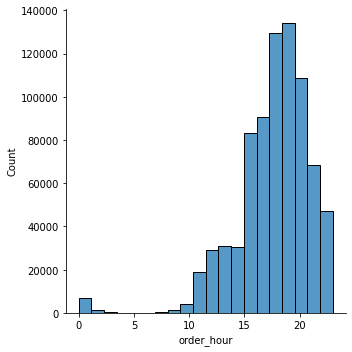

<Figure size 432x288 with 0 Axes>

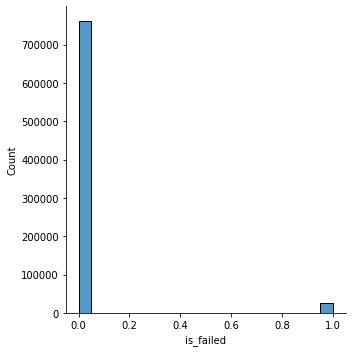

<Figure size 432x288 with 0 Axes>

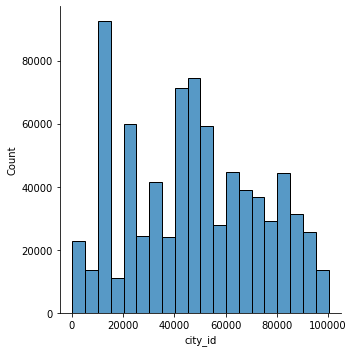

<Figure size 432x288 with 0 Axes>

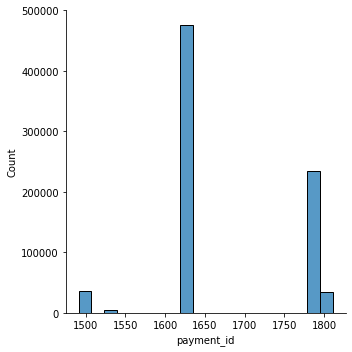

<Figure size 432x288 with 0 Axes>

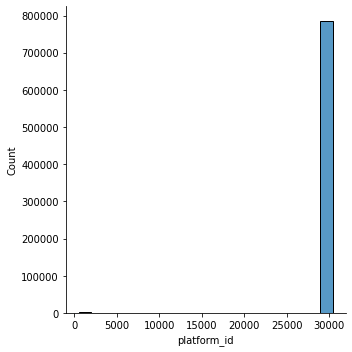

<Figure size 432x288 with 0 Axes>

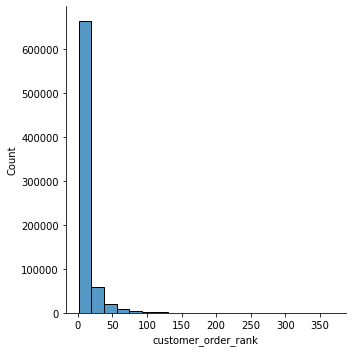

<Figure size 432x288 with 0 Axes>

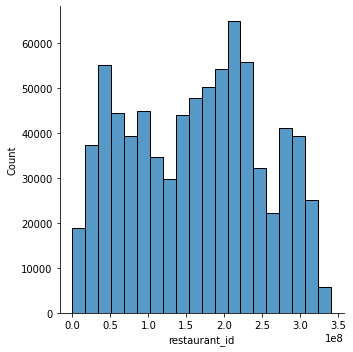

<Figure size 432x288 with 0 Axes>

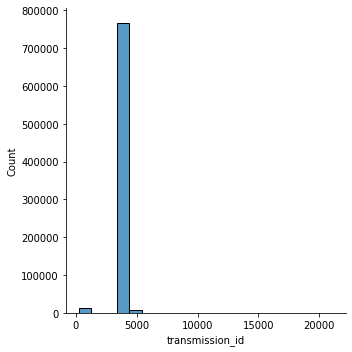

In [8]:
columns=['order_hour','is_failed','city_id','payment_id','platform_id','customer_order_rank','restaurant_id','transmission_id']
for col in columns:
    plt.figure()
    sns.displot(orders_df[col],bins=20)

Take aways
1. is_failed is heavily biased to 0
2. There is on dominant platfrom_ids

In [9]:
# analyzing the "count" for categorical columns to assess the feasibility of hot encoding
for col in columns:
    logger.info(f'For columns = {col}..')
    logger.info(f"""unique values = {len(orders_df[col].unique())}""")

INFO:Main_Churn_Perdictors:For columns = order_hour..
INFO:Main_Churn_Perdictors:unique values = 24
INFO:Main_Churn_Perdictors:For columns = is_failed..
INFO:Main_Churn_Perdictors:unique values = 2
INFO:Main_Churn_Perdictors:For columns = city_id..
INFO:Main_Churn_Perdictors:unique values = 3749
INFO:Main_Churn_Perdictors:For columns = payment_id..
INFO:Main_Churn_Perdictors:unique values = 5
INFO:Main_Churn_Perdictors:For columns = platform_id..
INFO:Main_Churn_Perdictors:unique values = 14
INFO:Main_Churn_Perdictors:For columns = customer_order_rank..
INFO:Main_Churn_Perdictors:unique values = 370
INFO:Main_Churn_Perdictors:For columns = restaurant_id..
INFO:Main_Churn_Perdictors:unique values = 13569
INFO:Main_Churn_Perdictors:For columns = transmission_id..
INFO:Main_Churn_Perdictors:unique values = 10


In [10]:
# verifying visuals numerically

In [11]:
logger.info(f"""order_df.is_failed normalized counts = \n{orders_df['is_failed'].value_counts(normalize = True)}""")
logger.info(f"""order_df.is_failed normalized counts = \n{orders_df['platform_id'].value_counts(normalize = True)}""")

INFO:Main_Churn_Perdictors:order_df.is_failed normalized counts = 
0    0.968514
1    0.031486
Name: is_failed, dtype: float64
INFO:Main_Churn_Perdictors:order_df.is_failed normalized counts = 
29463    0.307047
30231    0.275523
29815    0.202100
30359    0.131773
30391    0.031063
29751    0.024563
29495    0.014176
30423    0.008669
30199    0.002643
525      0.001391
30135    0.000753
22263    0.000295
22167    0.000004
22295    0.000001
Name: platform_id, dtype: float64


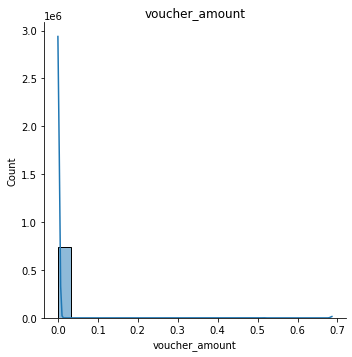

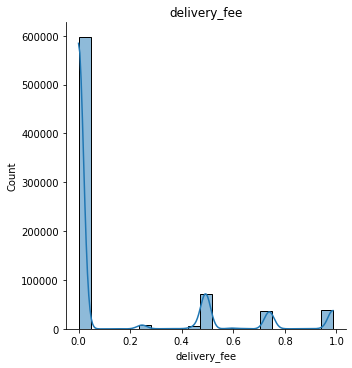

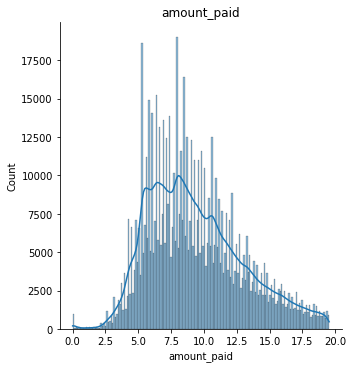

In [12]:
# KDE to plot continous variables
# function to plot given columns
# focus only on continous variables, as discreate have been analyzed via hist function

def kde_batch_numeric(df,columns,q=1):
    """
    df: dataframe to plot 
    columns: specific columns
    q: filtering thershold based on quantiles
    """
    for col in columns:
        if isinstance(df[col][0],(float,int)):
            val_q = np.quantile(a=df[col],q=q)
            filtered_data = df[col][df[col]<=val_q]
            sns.displot(filtered_data,kde=True)
            plt.title(col)
            plt.show()
        else:
            raise ValueError(f'Column {col} is not float or int')
            
kde_batch_numeric(df=orders_df,columns=['voucher_amount','delivery_fee','amount_paid'],q=0.95)

Takeaways
1. voucher amount is like an impluse signal, most probabably not very useful in prediction
2. amount paid distrbution mass is well distributed and can be of prediction power
3. delivery fee is heavily skewed

From the first quick analysis , we can say that the candidate features are:
1. customer_order_rank
2. is_failed
3. delivery_fee
4. amount_paid
5. payment_id
6. platform_id
7. order_date (indirectly by measuring order frequency)

In the first iterstion, we will ignore the city_id and restaurant_id as the number of unique values is high and we plan to use one-hot encoding to model categorical values in the beginning.
also voucher_amount is very sparse and distribution is highly skewed to zero, will ignore in 1st iteration


 # 2) Feature Generation
The feature generation code is created as follows
1. a set of small experimental function to explore
2. a clean function that generates the features given a data frame

In [13]:
orders_labeled_df = pd.merge(left=orders_df,right=labeled_df,on='customer_id')

In [14]:
orders_labeled_df['order_date'] = pd.to_datetime(orders_labeled_df['order_date'])
max_order_date = np.nanmax(orders_labeled_df['order_date'])
min_order_date = np.nanmin(orders_labeled_df['order_date'])
min_order_date,max_order_date

(numpy.datetime64('2012-05-17T00:00:00.000000000'),
 numpy.datetime64('2017-02-27T00:00:00.000000000'))

In [15]:
def get_mode_scalar(series):# wrapper to get scalar value, not a series
    return pd.Series(series).mode()[0]

In [16]:
def avg_days_between_orders(dates,default = -10): # need to revisit the default value , set to be 1 year
    if len(dates) <2:
        return default
    dates_series = pd.Series(data=pd.to_datetime(dates).values).sort_values()
    dates_series_lag1 = dates_series.shift(1)
    time_delta =  dates_series - dates_series_lag1
    time_delta_day = time_delta.apply(lambda x:x.days)
    return np.nanmean(time_delta_day)
    
avg_days_between_orders(dates=['2020-01-20','2020-01-23','2020-01-30'])

5.0

In [17]:
def time_since_last_order(dates,current_date):
    dates = pd.to_datetime(dates)
    max_date = np.nanmax(dates)
    current_date = pd.to_datetime(current_date)
    if current_date < max_date:
        raise ValueError('Current date must be >= max date in the dateset')
    return (current_date-max_date).days
x = time_since_last_order(dates=['2020-01-20','2020-01-23','2020-01-30'],current_date='2020-02-02')
type(x)

int

In [18]:
orders_labeled_df['order_date'] = pd.to_datetime(orders_labeled_df['order_date'])
orders_labeled_df['order_date_2'] = orders_labeled_df['order_date'] # quick hack to generate 2 features based on the same column

In [19]:
# aggregate data per customers 
# v1 aggregation is using, average, mode, max as needed, v2 should weight the average based on recency
# AFAIU : order_rank is the order of an order per customer, hence max of this number means the total number
# of orders for this customer up to this point of time
# Warning: this code chunk takes a lot of time, next to use python multi-processing
compute_orders_labeled_df_agg_1 = False
if compute_orders_labeled_df_agg_1: # switch to avoid long running time
    logger.info('Calculate compute_orders_labeled_df_agg_1')
    orders_labeled_df_agg_1 = orders_labeled_df.groupby(by='customer_id',as_index = False)\
            .agg({'customer_order_rank':np.nanmax,'is_failed':np.nanmean,\
                  'delivery_fee':np.nanmean,'amount_paid':np.nanmean,\
                  'payment_id':get_mode_scalar,'platform_id':get_mode_scalar,\
                  'is_returning_customer':get_mode_scalar,
                 'order_date':avg_days_between_orders,\
                  'order_date_2':lambda x:time_since_last_order(x,current_date=max_order_date)})

    orders_labeled_df_agg_1.rename(columns = {'order_date':'avg_days_between_orders'\
                                          ,'order_date_2':'time_since_last_order'},inplace=True)
    # caching the data as this phase takes time 
    orders_labeled_df_agg_1.to_csv('orders_labeled_df_agg_1.csv',index = False) 
else:
    logger.info('Load compute_orders_labeled_df_agg_1 from cache')
    orders_labeled_df_agg_1 = pd.read_csv('./orders_labeled_df_agg_1.csv')


INFO:Main_Churn_Perdictors:Load compute_orders_labeled_df_agg_1 from cache


In [20]:
# quick data cleaning first

In [21]:
orders_labeled_df_agg_1['time_since_last_order'][0]

618

In [22]:
def remove_outliers_quantiles(df,columns,q=0.99):
    # this function remove outliers based on quantiles, columns must be numeric
    n_rows = df.shape[0]
    running_idx = pd.Series(np.repeat(True,n_rows))
    for col in columns:
        if isinstance(df[col][0],(np.float_,np.int_)):
            
            val_q = np.quantile(a=df[col],q=q)
            idx = df[col]<=val_q
            running_idx = np.logical_and(running_idx,idx)

            row_to_remove_count = idx.value_counts().sort_values().values[0]
            logger.info(f"""Removing {row_to_remove_count} based on columns {col} which is
                {np.round(1.0*row_to_remove_count/n_rows,4)*100} % of the rows""")
        else:
            logger.error(f'Cannot remove outliers from column {col} as it is not numeric!')
        filterd_df = df.loc[running_idx,:]
        
    total_rows_removed = running_idx.value_counts().sort_values().values[0]
    logger.info(f"""Total rows remove = {total_rows_removed} which is 
            {np.round(1.0*total_rows_removed/n_rows,4)*100} % of the rows""")
    return filterd_df

cols = ['amount_paid','avg_days_between_orders','time_since_last_order']
orders_labeled_df_agg_filtered_1 = remove_outliers_quantiles(orders_labeled_df_agg_1,cols)

INFO:Main_Churn_Perdictors:Removing 2455 based on columns amount_paid which is
                1.0 % of the rows
INFO:Main_Churn_Perdictors:Removing 2446 based on columns avg_days_between_orders which is
                1.0 % of the rows
INFO:Main_Churn_Perdictors:Removing 2409 based on columns time_since_last_order which is
                0.98 % of the rows
INFO:Main_Churn_Perdictors:Total rows remove = 7274 which is 
            2.96 % of the rows


In [23]:
orders_labeled_df_agg_filtered_1.is_returning_customer.value_counts(normalize=True)

0    0.771313
1    0.228687
Name: is_returning_customer, dtype: float64

In [24]:
count = labeled_df.is_returning_customer.value_counts(normalize=True)
count.sort_values()

1    0.226139
0    0.773861
Name: is_returning_customer, dtype: float64

In [25]:
# the ratios should be the same, quick sanity check that the merge and filtering didn;t distore the ratios of classes

In [26]:
# balance the dataset using upsampling
# reason: intuitively we have a small dataset so losing samples is not required, and the computational power of local 
# machine should handle it
def upsample(df,target_col):
    if len(df[target_col].unique())!=2:
        raise ValueError('Numer of target unique values must = 2')
    count = df[target_col].value_counts(normalize=True).sort_values()
    minority_df = df.loc[df[target_col]==count.index[0],:]
    majority_df = df.loc[df[target_col]==count.index[1],:]
    # upsampling
    n_majority = majority_df.shape[0]
    minority_df_upsampled = minority_df.sample(n=n_majority,replace=True)
    balanced_df = majority_df.append(minority_df_upsampled,ignore_index = True)
    count_balanced = balanced_df[target_col].value_counts(normalize=True)
    return balanced_df
orders_labeled_df_agg_filtered_upsampled_1 = upsample(df=orders_labeled_df_agg_filtered_1\
                                                      ,target_col='is_returning_customer')
orders_labeled_df_agg_filtered_upsampled_1['is_returning_customer'].value_counts(normalize=True)

1    0.5
0    0.5
Name: is_returning_customer, dtype: float64

In [27]:
orders_labeled_df_agg_filtered_upsampled_1.dtypes

customer_id                 object
customer_order_rank        float64
is_failed                  float64
delivery_fee               float64
amount_paid                float64
payment_id                   int64
platform_id                  int64
is_returning_customer        int64
avg_days_between_orders    float64
time_since_last_order        int64
dtype: object

In [28]:
# one hot encoding for categorical variables 
orders_labeled_df_agg_filtered_upsampled_1.drop(columns=['customer_id'],inplace=True)


In [29]:
orders_labeled_df_agg_filtered_upsampled_1['payment_id'] = \
    orders_labeled_df_agg_filtered_upsampled_1['payment_id'].astype(str)
orders_labeled_df_agg_filtered_upsampled_1['platform_id'] = \
    orders_labeled_df_agg_filtered_upsampled_1['platform_id'].astype(str)
orders_labeled_df_agg_filtered_upsampled_1.dtypes

customer_order_rank        float64
is_failed                  float64
delivery_fee               float64
amount_paid                float64
payment_id                  object
platform_id                 object
is_returning_customer        int64
avg_days_between_orders    float64
time_since_last_order        int64
dtype: object

In [30]:
one_hot_encoding_df = pd.get_dummies(orders_labeled_df_agg_filtered_upsampled_1[['payment_id','platform_id']])
one_hot_encoding_df.head()

,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_22167,platform_id_22263,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,platform_id_525
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [31]:
orders_labeled_df_agg_filtered_upsampled_1.drop(columns=['payment_id','platform_id'],inplace=True)

In [32]:
orders_labeled_df_agg_filtered_upsampled_features_1 = pd.concat([orders_labeled_df_agg_filtered_upsampled_1,one_hot_encoding_df],axis='columns',ignore_index=False)
orders_labeled_df_agg_filtered_upsampled_features_1.head()

,customer_order_rank,is_failed,delivery_fee,amount_paid,is_returning_customer,avg_days_between_orders,time_since_last_order,payment_id_1491,payment_id_1523,payment_id_1619,...,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,platform_id_525
0,1.0,0.0,0.000,11.4696,0,-10.0,618,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,0.0,0.000,9.5580,0,-10.0,395,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1.0,0.0,0.493,9.8235,0,-10.0,22,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1.0,0.0,0.493,5.1507,0,-10.0,573,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0.0,0.000,10.9386,0,259.0,30,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
orders_labeled_df_agg_filtered_upsampled_features_1.columns

Index(['customer_order_rank', 'is_failed', 'delivery_fee', 'amount_paid',
       'is_returning_customer', 'avg_days_between_orders',
       'time_since_last_order', 'payment_id_1491', 'payment_id_1523',
       'payment_id_1619', 'payment_id_1779', 'payment_id_1811',
       'platform_id_22167', 'platform_id_22263', 'platform_id_29463',
       'platform_id_29495', 'platform_id_29751', 'platform_id_29815',
       'platform_id_30135', 'platform_id_30199', 'platform_id_30231',
       'platform_id_30359', 'platform_id_30391', 'platform_id_30423',
       'platform_id_525'],
      dtype='object')

# 3) Modeling+Testing , iteration 1 , logistic regression

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [39]:
# drop any row that has na, as fit methods doesn't handle it, need to find better nan imputation method
# like interpolation
orders_labeled_df_agg_filtered_upsampled_features_not_nan_1 = \
    orders_labeled_df_agg_filtered_upsampled_features_1.dropna()
n_all = orders_labeled_df_agg_filtered_upsampled_features_1.shape[0]
n_na_drop = orders_labeled_df_agg_filtered_upsampled_features_not_nan_1.shape[0]
(n_na_drop-n_all)/n_all # negligible fraction

-0.00446350809963421

In [40]:
X_cols = ['customer_order_rank', 'is_failed', 'delivery_fee', 'amount_paid',
        'avg_days_between_orders',
       'time_since_last_order', 'payment_id_1491', 'payment_id_1523',
       'payment_id_1619', 'payment_id_1779', 'payment_id_1811',
       'platform_id_22167', 'platform_id_22263', 'platform_id_29463',
       'platform_id_29495', 'platform_id_29751', 'platform_id_29815',
       'platform_id_30135', 'platform_id_30199', 'platform_id_30231',
       'platform_id_30359', 'platform_id_30391', 'platform_id_30423',
       'platform_id_525']
y_col = 'is_returning_customer'
X = orders_labeled_df_agg_filtered_upsampled_features_not_nan_1.loc[:,X_cols]
y = orders_labeled_df_agg_filtered_upsampled_features_not_nan_1.loc[:,y_col]

## Model1 , logistic regression , to use as a benchmark

In [ ]:
parameters = {'C':[0.1,1,10]} # different C's to test how stronger regularization affect the final score
scores = ['roc_auc','precision','recall']
best_scores_lr_dict = dict()
for score in scores:
    logger.info(f'Using score {score}')
    gs_lr = GridSearchCV(estimator=LogisticRegression(),param_grid=parameters, cv=3, scoring=score,verbose=0)
    gs_lr_fit = gs_lr.fit(X=X,y=y)
    logger.info(f'Best estimator = {gs_lr_fit.best_estimator_}')
    logger.info(f'best {score} = {gs_lr_fit.best_score_}')
    best_scores_lr_dict[score] = gs_lr_fit.best_score_

INFO:Main_Churn_Perdictors:Using score roc_auc
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [ ]:
best_scores_lr_dict

## Model 2) Adaboost as a nonlinear , ensemble model

In [ ]:
# experiment adaboost as an ensemble not linear model
# the basic assumption is that features like avg days between purhcases and time since last purchase, follows a non linear 
# behavior when affecting the target variable

In [ ]:
parameters = {'n_estimators':[20,50,100],'learning_rate':[0.1,1,10]}
scores = ['roc_auc','precision','recall']
best_scores_ada_dict = dict()
for score in scores:
    logger.info(f'Using score {score}')
    gs_ada = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=parameters, cv=3, scoring=score,verbose=10)
    gs_ada_fit = gs_ada.fit(X=X,y=y)
    logger.info(f'Best estimator = {gs_ada_fit.best_estimator_}')
    logger.info(f'best {score} = {gs_ada_fit.best_score_}')
    best_scores_ada_dict[score] = gs_ada_fit.best_score_

In [ ]:
best_scores_ada_dict

## Conclusion
1. Adaboost model gives better performance (slightly) over logistic regression
2. Nonlineariy exists in feature vector target correlation, further non-linear models, like neural networks, can perform better

## Future Work
1. apply customer segmentation to further understand customer behavior, for example , we can find 4 clusters based on 
 frequency and paying level of customers, divided into high / low leverls
2. apply NN to assign new customers to one of the segments
3. experiment different models for each cusotmers , for example, adaboost model might perform the best in the
    most frequent, highest paying customers, but logistic regression will perform the best in 
    low frequency low paying customers
4. This 2 layer architecure despite being complex, but will be more interpretable to stakeholders and eventually 
  can lead to better results than "one-size fits all" model

Backlog
1. improve historgrams
2. user order_date for weighting the samples (recency)
3. user distributions to further reduce the one-hot encoding results
4. consider per days orders 